## Introduction to the COVID-19 Open Research Dataset

The COVID-19 Open Research Dataset (CORD-19) is a collection of over 50,000 scholarly articles - including over 40,000 with full text - about COVID-19, SARS-CoV-2, and related coronaviruses. This dataset has been made freely available with the goal to aid research communities combat the COVID-19 pandemic. It has been made available by the Allen Institute for AI in partnership with leading research groups to prepare and distribute the COVID-19 Open Research Dataset (CORD-19), in response to the COVID-19 pandemic.

During this lab you will learn how to process and analyze a subset of the articles present in the dataset, group them together into a series of clusters, and use Automated ML to train a machine learning model capable of classifying new articles as they are published.

### Setup

We will start off by installing a few packages, such as `nltk` for text processing and `wordcloud`, `seaborn`, and `yellowbrick` for various visualizations.

In [32]:
!pip install nltk
!pip install wordcloud
!pip install seaborn
!pip install yellowbrick

We'll first download stopwords and the Punkt tokenizer models present in the `nltk` package, in order to be able to process the articles

In [33]:
import nltk

nltk.download('punkt')
nltk.download('stopwords')

[nltk_data] Downloading package punkt to /home/azureuser/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /home/azureuser/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

We'll also import the rest of the modules needed in this notebook, and do a quick sanity-check on the Azure ML SDK version

In [34]:
import os
import json
from string import punctuation

import pandas as pd
import seaborn as sns
sns.set_palette('Set2')
from wordcloud import WordCloud
import matplotlib.pyplot as plt
from yellowbrick.cluster import KElbowVisualizer
from gensim.models.doc2vec import Doc2Vec, TaggedDocument
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.cluster import KMeans, SpectralClustering, DBSCAN, Birch, AgglomerativeClustering
from sklearn.metrics import roc_auc_score
from nltk import word_tokenize, sent_tokenize
from nltk.stem import SnowballStemmer, PorterStemmer

from azureml.core import Workspace, Datastore, Dataset, VERSION

print("Azure ML SDK Version: ", VERSION)

Azure ML SDK Version:  1.48.0


## Load the Covid-19 data

CORD-19 has been uploaded as an Azure Open Dataset, we will connect to it and use it's API to download the dataset locally.

In [35]:
covid_dirname = 'opendata'

cord19_dataset = Dataset.File.from_files('https://stgai2023.blob.core.windows.net/' + covid_dirname)
mount = cord19_dataset.mount()

covid_dirpath = os.path.join(mount.mount_point, covid_dirname)

Not mounting as a volume: No datastore info was found, volume mount would not be attempted.. 
Falling back to dataflow mount.


Display a sample of the dataset (top 5 rows).

In [36]:
mount.start()

# Load metadata.csv, as it contains a list of all the articles and their corresponding titles/authors/contents.
metadata_filename = os.path.join(covid_dirpath, 'metadata.csv')

metadata = pd.read_csv(metadata_filename)
metadata.sample(5)

/anaconda/envs/azureml_py38/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3194: DtypeWarning: Columns (1,4,5,6,13,14,15,16) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


,cord_uid,sha,source_x,title,doi,pmcid,pubmed_id,license,abstract,publish_time,authors,journal,mag_id,who_covidence_id,arxiv_id,pdf_json_files,pmc_json_files,url,s2_id
172373,tccvl4j6,NaN,Medline,Psychological Interventions for Individuals Wi...,10.3389/fped.2022.782104,NaN,3.53863e+07,unk,"Background With current medical advancements, ...",2022,"Jefferies, Morgan; Peart, Taylor; Perrier, Lau...",Frontiers in pediatrics,NaN,NaN,NaN,NaN,NaN,https://doi.org/10.3389/fped.2022.782104; http...,247643982.0
768580,5dh08a2q,04a90b897313d12c25f42f073ed3dd7c33ab4881,Elsevier; Medline; PMC; WHO,COVID-19 and Stroke: A Review,10.1016/j.hest.2020.11.001,PMC7670261,3.32253e+07,no-cc,COVID-19 patients have presented with a wide r...,2020-11-17,"Qi, Xiaoming; Keith, Kristin A.; Huang, Jason H.",Brain Hemorrhages,NaN,NaN,NaN,document_parses/pdf_json/04a90b897313d12c25f42...,document_parses/pmc_json/PMC7670261.xml.json,https://www.sciencedirect.com/science/article/...,226966840.0
562003,xjavj9ct,NaN,WHO,[Countermeasures and treatment for aortic acut...,NaN,NaN,NaN,unk,The novel coronavirus pneumonia (NCP) has cost...,2020,"Si, Y; Sun, X F; Zhong, M; Yue, J N; Fu, W G",Zhonghua Wai Ke Za Zhi,NaN,#32066206,NaN,NaN,NaN,NaN,211160130.0
589131,301vigvx,NaN,WHO,Medical student views on returning to clinical...,NaN,NaN,NaN,unk,NaN,2020,"Hickland, Maria M; Gosney, Eleanor R; Hare, Ka...",Med Educ Online,NaN,#690582,NaN,NaN,NaN,NaN,220847163.0
483910,khbcgq3d,NaN,WHO,Sex and age differences in clinically signific...,NaN,NaN,NaN,unk,OBJECTIVES: To identify sex and age difference...,2020,"Hammarberg, Karin; Tran, Thach; Kirkman, Maggi...",BMJ Open,NaN,#944951,NaN,NaN,NaN,NaN,227166462.0


Some of the articles do not have any associated documents, so we will filter those out.

In [37]:
metadata_with_docs = metadata[metadata['pdf_json_files'].isna() == False]

print(f'Dataset contains {metadata.shape[0]} entries, out of which {metadata_with_docs.shape[0]} have associated json documents')

Dataset contains 1056660 entries, out of which 373766 have associated json documents


Display the percentage of items in the dataset that have associated JSON documents (research papers that have extra metadata associated with them).

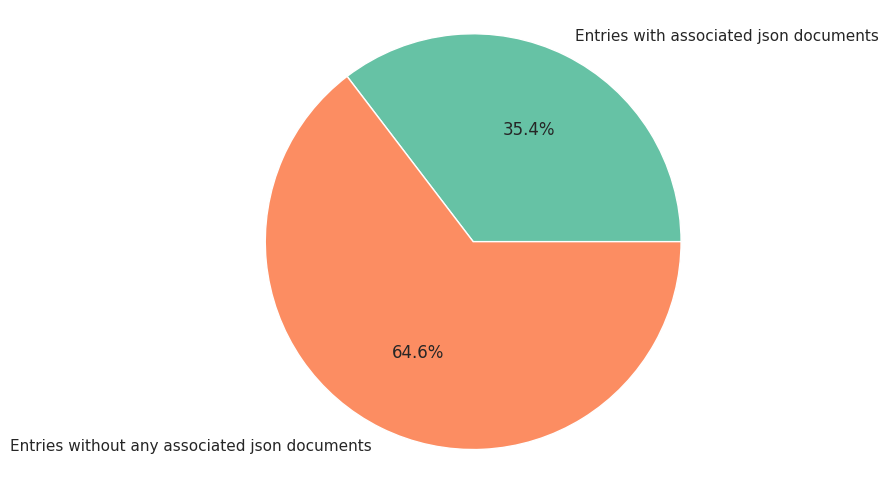

In [38]:
doc_counts = [metadata_with_docs.shape[0], metadata.shape[0] - metadata_with_docs.shape[0]]
doc_labels = ['Entries with associated json documents', 'Entries without any associated json documents']

fig, ax = plt.subplots()
ax.pie(doc_counts, labels=doc_labels, autopct='%1.1f%%')
ax.axis('equal')
plt.show()

## Investigate individual items

Let's load an example entry from the dataset.

In [39]:
# Change the document index in order to preview a different article
DOCUMENT_INDEX = 0 
example_entry = metadata_with_docs.iloc[DOCUMENT_INDEX]

filepath = os.path.join(covid_dirpath, example_entry['pdf_json_files'])
print(f'Document local filepath: {filepath}')

Document local filepath: /tmp/tmpgnqv54ah/opendata/document_parses/pdf_json/d1aafb70c066a2068b02786f8929fd9c900897fb.json


Next, we will display the list of elements that are available for the selected document.

In [40]:
try:
    with open(filepath, 'r') as f:
        data = json.load(f)
        
except FileNotFoundError as e:
    # in case the mount context has been closed
    mount.start()
    with open(filepath, 'r') as f:
        data = json.load(f)
        
print(f'Data elements: { ", ".join(data.keys())}' )

Data elements: paper_id, metadata, abstract, body_text, bib_entries, ref_entries, back_matter


View the full text version of the document.

In [41]:
for p in data['body_text']:
    print(p['text'], '\n')

Mycoplasma pneumoniae is a common cause of upper and lower respiratory tract infections. It remains one of the most frequent causes of atypical pneumonia particu-larly among young adults. [1, 2, 3, 4, 5] Although it is highly transmissible, most infections caused by this organism are relatively minor and include pharyngitis, tracheobronchitis, bronchiolitis, and croup with one fifth of in-fections being asymptomatic. [6, 7] Only 3 -10% of infected subjects develop symptoms consistent with bronchopneumonia and mortality from infection is rare. [6, 7] The organism is fastidious and difficult to grow on cultures. Therefore, diagnosis of infections caused by this organism is usually confirmed with serological tests or polymerase chain reaction-gene amplification techniques. At King Abdulaziz University Hospital (KAUH), Jeddah, Saudi Arabia, the facility to perform Mycoplasma culture has been available since January 1997. As published information concerning M. pneumoniae infections in Saudi

## Stop words

Here's a quote from Stanford's NLP team that will provide some context on stop words and their intended usage:

_"Sometimes, some extremely common words which would appear to be of little value in helping select documents matching a user need are excluded from the vocabulary entirely. These words are called stop words . The general strategy for determining a stop list is to sort the terms by collection frequency (the total number of times each term appears in the document collection), and then to take the most frequent terms, often hand-filtered for their semantic content relative to the domain of the documents being indexed, as a stop list , the members of which are then discarded during indexing."_

Let's investigate the stop words list that we will use to clean our data. Note that apart from the standard stopwords, we will also remove any punctuation and also any occurrences of *et al.*, as they are often found in academic articles.

In [42]:
stop_tokens = nltk.corpus.stopwords.words('english') + list(punctuation) + ['et', 'al.']
print(stop_tokens)

['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more', 'most', 'other', 'some', 'such', 'no', 'nor', 'not', 'only', 'own', 'same', 'so', 'than', '

The code below will be used to read the text associated with a series of articles, remove stop words from their text, and reduce) inflected words to their base form (stemming).

**NOTE**:

If you are not familiar with Python code, just execute the following cell and continue with the notebook. Understanding the code below is not require for understanding and following the overall flow of the notebook.

In [43]:
class Reader:
    """Class used to read the files associated with an article"""
    
    def __init__(self):
        self.stemmer = SnowballStemmer('english')
    
    def read_file_to_json(self, filepath):
        try:
            with open(filepath, 'r') as f:
                data = json.load(f)
        except FileNotFoundError as e:
            mount.start()
            with open(filepath, 'r') as f:
                data = json.load(f)
                
        return data
    
    def parse_document(self, document_index):
        document = metadata_with_docs.iloc[document_index]
        
        # One article can have multiple associated documents
        words = []
        for filename in document['pdf_json_files'].split('; '):
            filepath = '{0}/{1}'.format(covid_dirpath, filename)
            data = self.read_file_to_json(filepath)

            # Split each paragraph into multiple sentences first, in order to improve the performance of the word tokenizer
            text = data['body_text']
            for paragraph in text:
                p_sentences = sent_tokenize(paragraph['text'])

                # Split each sentence into words, while making sure to remove the stopwords and stem the words
                for p_sentence in p_sentences:
                    sentence = [ self.stemmer.stem(word) for word in word_tokenize(p_sentence) if word.isalpha() and word.lower() not in stop_tokens ]
                    words.extend(sentence)
    
        return (words, document['cord_uid'])
        

class Corpus:
    """An iterator that reads all sentences from the first N documents"""
    
    def __init__(self, n_documents):
        self.n_documents = n_documents
        self.stemmer = SnowballStemmer('english')
        self.reader = Reader()
        
    def __iter__(self):
         for document_index in range(0, self.n_documents):   
            words, document_id = self.reader.parse_document(document_index)
            yield TaggedDocument(words, document_id)
            
    def plain_iter(self):
        for document_index in range(0, self.n_documents):  
            words, document_id = self.reader.parse_document(document_index)
            yield (words, document_id)

## Encoding documents as vectors

In this lab, we're using a subset of 1000 articles to train a Machine Learning model that encodes text documents into numerical vectors (a document embedding model). 

Training a document embedding model takes a significant amount of time, and for this reason we already provide a trained model. We also provide the code below in case you want to get more details about the process. Running the next two cells will result in loading the already existing model.

In [44]:
N_DOCUMENTS = 500

In [45]:
%%time

model_filename = f'covid_embeddings_model_{N_DOCUMENTS}_docs.w2v'

if (os.path.exists(model_filename)):
    model = Doc2Vec.load(model_filename)
    print(f'Done, loaded word2vec model with { len(model.wv.vocab) } words.')
else:
    model = Doc2Vec(Corpus(N_DOCUMENTS), vector_size=128, batch_words=10)
    model.save(model_filename)
    print(f'Done, trained word2vec model with { len(model.wv.vocab) } words.')

Done, loaded word2vec model with 12788 words.
CPU times: user 139 ms, sys: 16.4 ms, total: 156 ms
Wall time: 550 ms


## Word frequencies

Let's analyze the relative frequencies of words in the corpus of articles. We will display a word cloud to provide a visual representation of these relative frequencies.

In [46]:
word_frequencies = { key: model.wv.vocab[key].count for key in model.wv.vocab }

(-0.5, 1023.5, 767.5, -0.5)

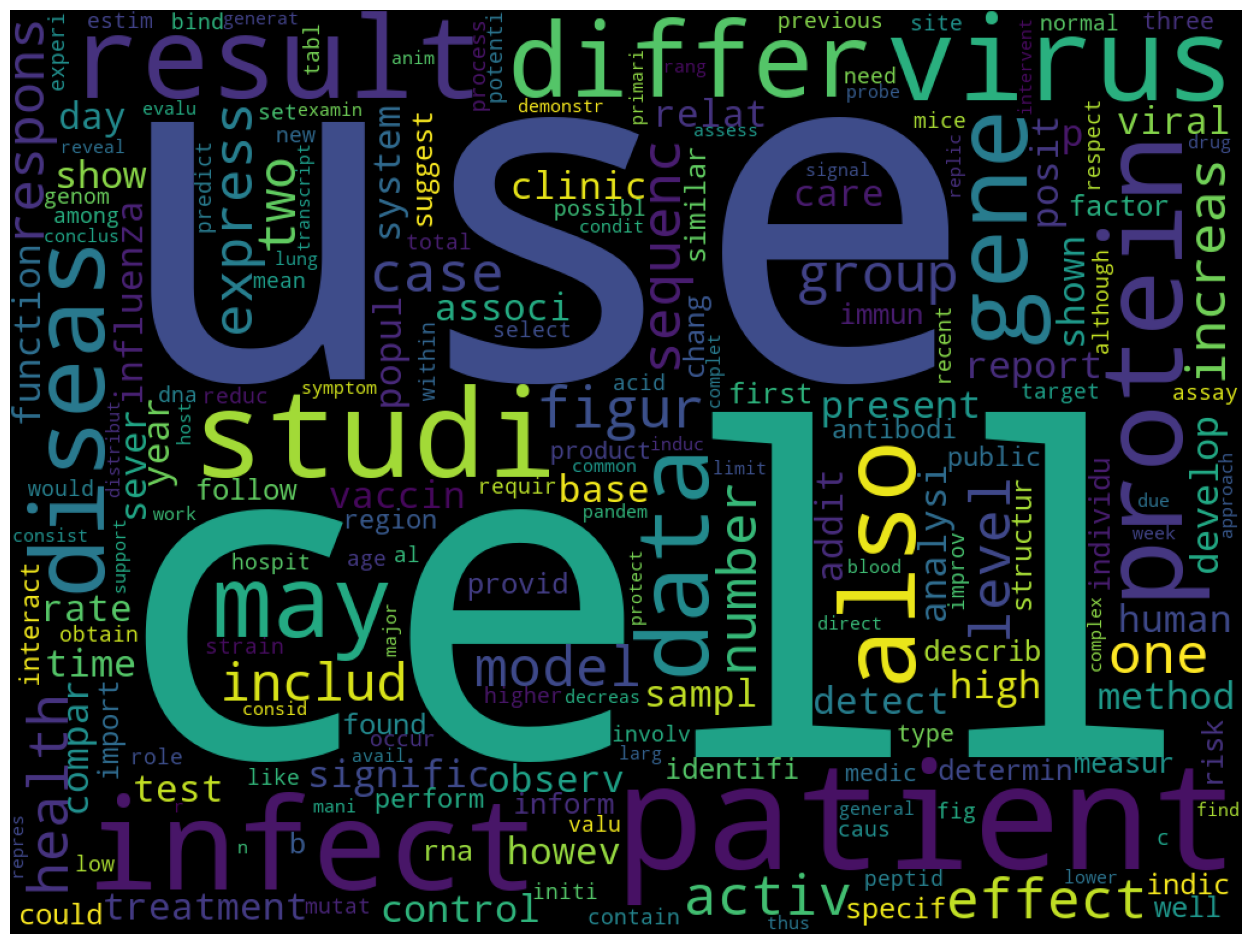

In [47]:
cloud = WordCloud(width=1024, height=768).generate_from_frequencies(word_frequencies)
plt.figure(figsize=(16,12))
plt.imshow(cloud, interpolation='antialiased')
plt.axis("off")

## Embedding documents

Below is an example on how we embed (transform from text to numerical vector) one of the documents.

In [48]:
words, doc_id = Reader().parse_document(DOCUMENT_INDEX)
model.infer_vector(words)

array([ 0.9183375 , -0.5484148 , -1.1727985 , -0.44200692, -1.4882743 ,
        1.5971193 ,  0.25249422,  1.4386889 ,  0.11069403,  0.01869632,
       -0.03433689,  0.04014184, -1.8920712 , -0.40814614,  0.17914829,
       -0.75536954, -0.19289397,  0.1072115 ,  0.34164435,  0.27885622,
        1.2381653 , -0.67821777, -1.2586812 , -0.46961817, -0.55361044,
       -0.35280636,  0.6397773 , -0.7169817 , -1.1773633 , -0.06409138,
        1.6338599 ,  1.6099027 ,  1.4316174 , -2.6598046 , -0.17131795,
        1.0553141 , -0.20653445,  0.1715204 , -0.59696615,  0.30296814,
       -0.34363514, -3.2224078 ,  0.58219147,  0.60820746,  0.4133889 ,
        1.8492261 ,  0.37979496,  1.1150265 ,  0.00748464, -0.5344145 ,
        1.1571776 ,  0.00375293,  1.1958971 ,  0.20311448, -0.8640267 ,
       -0.06692117, -1.3188636 ,  0.98605627,  0.12839152, -1.3303347 ,
        0.4001897 , -1.9354408 ,  0.378585  ,  0.08164609,  2.0919795 ,
        0.9022535 , -0.53272325, -0.20810679,  1.8415123 , -0.25

And this is an example of a trivial "document" (containing a single, trivial sentence) going through the same process. Notice how, regardless of the length of the sentence, the result vector is always the same size - the `vector_size` argument used while training the `Doc2Vec` model.

This is very important in the following stages of the process, when we are working with multiple documents.

In [49]:
model.infer_vector(['human', 'love', 'cat', 'dog'])

array([ 3.72307152e-02, -3.28468680e-02, -1.94933303e-02, -1.55603886e-02,
       -4.70124371e-02,  1.97712593e-02, -1.42549700e-03,  2.70858966e-03,
        9.41782817e-03,  2.49006459e-03, -1.17210001e-02, -2.41366457e-02,
       -1.68268774e-02, -5.44547278e-04, -8.69724783e-04, -8.07079393e-03,
        1.09321335e-02,  2.96460046e-03,  7.19045149e-03,  1.34809846e-02,
       -3.96901090e-03, -2.98858937e-02, -3.36266458e-02, -8.03390425e-03,
        1.78914815e-02,  2.94058234e-03,  3.23094651e-02, -3.29109058e-02,
       -2.55851503e-02,  1.81323346e-02,  2.50095986e-02,  4.59306017e-02,
        6.68551028e-03, -2.51452029e-02, -2.08943225e-02,  3.31023447e-02,
       -6.42279536e-03,  1.68108370e-03,  9.12493095e-03,  2.71803476e-02,
       -6.08606590e-03, -4.10276577e-02,  6.51996490e-03,  8.12334707e-04,
       -1.17280837e-02,  1.83622558e-02,  6.65546767e-03,  1.87680926e-02,
       -1.83345675e-02, -2.59496854e-03,  1.49731245e-03, -1.16974954e-02,
        2.01350134e-02,  

The resulting vectors will look more or less similar, depending on how different the contents of the articles are themselves. See below the differences resulting from a single word change - some of the values significantly overlap, while others are quite different if not opposite.

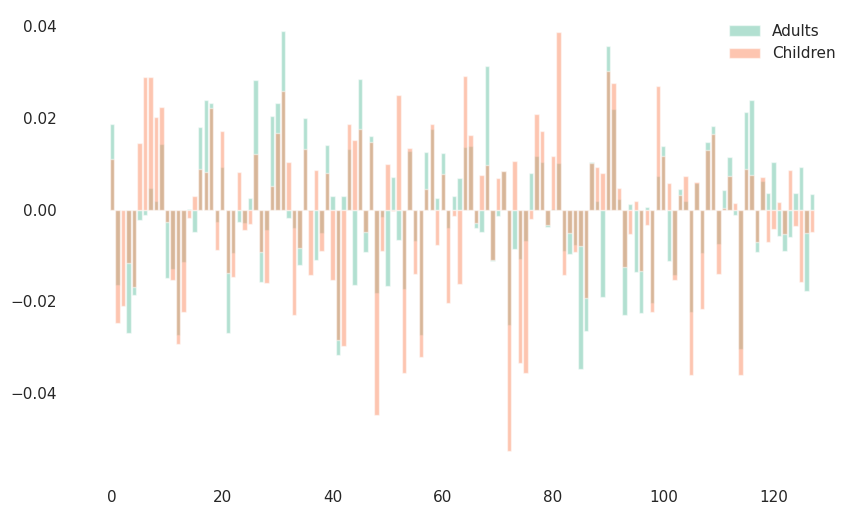

In [50]:
adult_vector = model.infer_vector(['adult', 'love', 'cat', 'dog'])
child_vector = model.infer_vector(['child', 'love', 'cat', 'dog'])
labels = range(0, 128) 

plt.bar(labels, adult_vector, align='center', alpha=0.5)
plt.bar(labels, child_vector, align='center', alpha=0.5)
plt.legend(['Adults', 'Children'])
plt.show()

Let's now do the same for the same for all the documents we're focusing on.

In [51]:
%%time

word_vectors = []
ids = []

for (words, doc_id) in Corpus(N_DOCUMENTS).plain_iter():
    ids.append(doc_id)
    word_vector = model.infer_vector(words)
    word_vectors.append(word_vector)
    if len(word_vectors) % 100 == 0:
        print(f'Processed {len(word_vectors)} documents.')

Processed 100 documents.
Processed 200 documents.
Processed 300 documents.
Processed 400 documents.
Processed 500 documents.
CPU times: user 1min, sys: 89.1 ms, total: 1min
Wall time: 1min 43s


Now that we've finished reading the articles, we can dismount the dataset in order to free up resources

In [52]:
mount.stop()

## Covid-19 documents prepared for Machine Learning

We'll create a new DataFrame using the word vectors we've just calculated, this is the numerical form of the documents which is ready for Machine Learning workloads.

In [53]:
wv_df = pd.DataFrame(word_vectors, index=ids)
wv_df

,0,1,2,3,4,5,6,7,8,9,...,118,119,120,121,122,123,124,125,126,127
ug7v899j,1.010748,-0.751633,-1.266447,-0.401128,-1.615343,1.545583,0.126947,1.444858,0.078159,-0.077132,...,1.062036,0.145263,0.296889,0.077305,0.575603,1.250086,-0.314545,-0.319977,-0.089638,0.132216
02tnwd4m,0.893951,-0.832215,-0.188300,0.238277,-2.363263,0.582332,-0.817200,0.580686,0.495807,-0.594539,...,1.210632,0.487589,-0.071829,0.116509,0.911905,0.618028,0.994307,-0.550212,1.302168,0.992603
ejv2xln0,-0.111930,-1.181670,-1.466820,0.500621,-2.047833,0.995783,-0.537943,1.581374,-0.368677,0.240012,...,0.209769,-0.510112,0.118183,1.098717,0.885468,2.134356,0.617166,-1.220858,0.322200,2.527758
2b73a28n,0.066288,-0.028891,1.383364,-1.043560,-0.809520,1.446986,0.441030,2.447193,0.297107,-0.723137,...,1.598631,-0.129294,0.778600,1.279774,-0.468407,3.546814,-1.595978,-2.338167,0.574311,2.193070
9785vg6d,0.760145,0.537667,-0.693255,-0.883724,-1.125465,1.360442,0.475616,1.039404,0.697757,0.124097,...,0.900206,0.118098,-0.109738,1.107324,0.188448,1.827301,-1.310135,0.066763,0.332375,0.471162
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
sn1a7ikq,0.271897,-1.232699,-4.268278,0.489203,0.024945,4.307676,0.686880,6.370641,-2.309317,0.849044,...,-0.028406,-0.282785,2.388615,2.476805,-1.847980,1.875314,-0.309674,-2.363565,-0.676983,-1.168320
0gt21051,2.347455,-0.164921,-1.452156,-1.834607,-3.707367,0.761698,-2.178002,-0.801133,-0.759637,1.425474,...,1.208553,-2.976055,-0.771656,-0.308590,-0.579366,1.184124,-0.434551,1.663818,-0.973883,2.177636
d3a06n3f,1.510717,-0.526868,-0.326240,-0.100148,-2.315341,1.210150,-0.591709,1.759198,0.238458,0.102013,...,2.400673,0.666660,-1.394477,-1.269233,-1.244131,0.852521,-1.130056,-1.672238,1.824665,1.386341
c2nuh2yc,0.065088,-2.826931,0.280311,0.857017,-2.533526,0.531634,0.378065,0.614064,0.801539,0.685459,...,1.078107,-0.374132,-0.796183,-0.388818,0.443023,3.197465,-0.357270,0.028587,0.616816,2.199785


We'll join the DataFrame containing the numerical embeddings with the original dataset.

In [54]:
indexed_metadata = metadata_with_docs.set_index('cord_uid')
metadata_with_embeddings = pd.concat([indexed_metadata.iloc[:N_DOCUMENTS], wv_df], axis=1)
metadata_with_embeddings

,sha,source_x,title,doi,pmcid,pubmed_id,license,abstract,publish_time,authors,...,118,119,120,121,122,123,124,125,126,127
cord_uid,,,,,,,,,,,,,,,,,,,,,
ug7v899j,d1aafb70c066a2068b02786f8929fd9c900897fb,PMC,Clinical features of culture-proven Mycoplasma...,10.1186/1471-2334-1-6,PMC35282,11472636,no-cc,OBJECTIVE: This retrospective chart review des...,2001-07-04,"Madani, Tariq A; Al-Ghamdi, Aisha A",...,1.062036,0.145263,0.296889,0.077305,0.575603,1.250086,-0.314545,-0.319977,-0.089638,0.132216
02tnwd4m,6b0567729c2143a66d737eb0a2f63f2dce2e5a7d,PMC,Nitric oxide: a pro-inflammatory mediator in l...,10.1186/rr14,PMC59543,11667967,no-cc,Inflammatory diseases of the respiratory tract...,2000-08-15,"Vliet, Albert van der; Eiserich, Jason P; Cros...",...,1.210632,0.487589,-0.071829,0.116509,0.911905,0.618028,0.994307,-0.550212,1.302168,0.992603
ejv2xln0,06ced00a5fc04215949aa72528f2eeaae1d58927,PMC,Surfactant protein-D and pulmonary host defense,10.1186/rr19,PMC59549,11667972,no-cc,Surfactant protein-D (SP-D) participates in th...,2000-08-25,"Crouch, Erika C",...,0.209769,-0.510112,0.118183,1.098717,0.885468,2.134356,0.617166,-1.220858,0.322200,2.527758
2b73a28n,348055649b6b8cf2b9a376498df9bf41f7123605,PMC,Role of endothelin-1 in lung disease,10.1186/rr44,PMC59574,11686871,no-cc,Endothelin-1 (ET-1) is a 21 amino acid peptide...,2001-02-22,"Fagan, Karen A; McMurtry, Ivan F; Rodman, David M",...,1.598631,-0.129294,0.778600,1.279774,-0.468407,3.546814,-1.595978,-2.338167,0.574311,2.193070
9785vg6d,5f48792a5fa08bed9f56016f4981ae2ca6031b32,PMC,Gene expression in epithelial cells in respons...,10.1186/rr61,PMC59580,11686888,no-cc,Respiratory syncytial virus (RSV) and pneumoni...,2001-05-11,"Domachowske, Joseph B; Bonville, Cynthia A; Ro...",...,0.900206,0.118098,-0.109738,1.107324,0.188448,1.827301,-1.310135,0.066763,0.332375,0.471162
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
sn1a7ikq,bb3716d66667c66f6f79b37c765388cd334f2cad,PMC,Tylosema esculentum (Marama) Tuber and Bean Ex...,10.1155/2011/284795,PMC3057194,21423688,cc-by,Tylosema esculentum (marama) beans and tubers ...,2011-02-20,"Chingwaru, Walter; Majinda, Runner T.; Yeboah,...",...,-0.028406,-0.282785,2.388615,2.476805,-1.847980,1.875314,-0.309674,-2.363565,-0.676983,-1.168320
0gt21051,c44a9d064faca56bd284971828e4db13e656365c; 4040...,PMC,Autonomous Targeting of Infectious Superspread...,10.1371/journal.pcbi.1002015,PMC3060167,21483468,cc-by,"Infectious disease treatments, both pharmaceut...",2011-03-17,"Metzger, Vincent T.; Lloyd-Smith, James O.; We...",...,1.208553,-2.976055,-0.771656,-0.308590,-0.579366,1.184124,-0.434551,1.663818,-0.973883,2.177636
d3a06n3f,6efeb37a50a81c7769a49bcf030e54b148bd1fbd,PMC,Screening of Random Peptide Library of Hemaggl...,10.1371/journal.pone.0018016,PMC3060926,21437206,cc-by,The antigenic structure of the membrane protei...,2011-03-18,"Xu, Wanghui; Han, Lu; Lin, Zhanglin",...,2.400673,0.666660,-1.394477,-1.269233,-1.244131,0.852521,-1.130056,-1.672238,1.824665,1.386341


## Preparing for clustering documents

One of the challenges with clustering is to find the ideal number of clusters to look for. The elbow method is one of the most common approaches.

We're visualizing an elbow metric (the "distortion" score) and trying to find a point where it stops decreasing with the number of clusters.


/anaconda/envs/azureml_py38/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/anaconda/envs/azureml_py38/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/anaconda/envs/azureml_py38/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/anaconda/envs/azureml_py38/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/ana

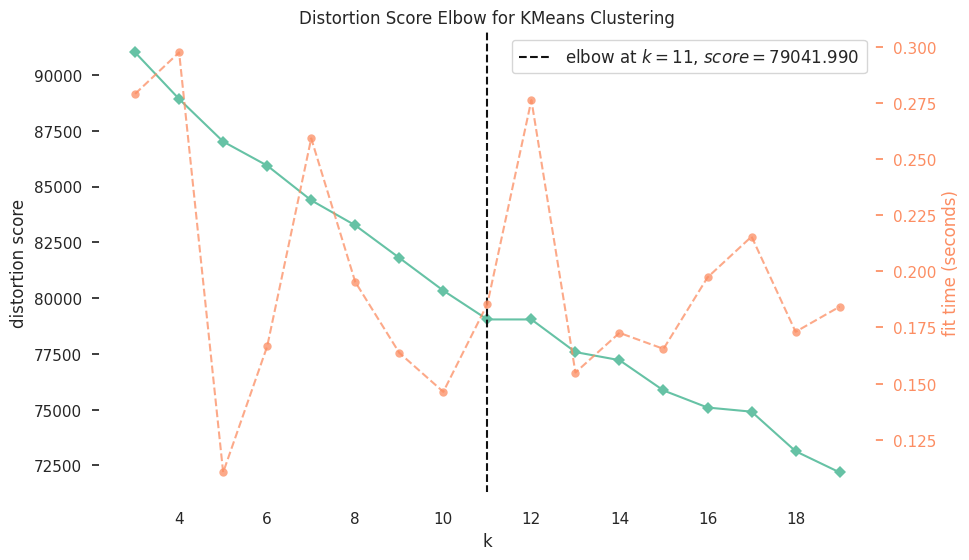

In [55]:
visualizer = KElbowVisualizer(KMeans(), k=(3,20))
visualizer.fit(wv_df)

visualizer.show()

## Clustering documents

We've determined the acceptable value for the clusters, so let's use Machine Learning to determine those clusters. We'll use the classic KMeans algorithm to do this.

In [56]:
clusterer = KMeans(12 if visualizer.elbow_value_ > 12 else visualizer.elbow_value_)
clusterer.fit(wv_df)
clusters = clusterer.labels_

/anaconda/envs/azureml_py38/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


We'll perform a quick visual check on the clusters. In order to be able to visualize 128 dimensions (which is the size of the word vectors) in a 2-D space, we'll use the PCA (Principal Component Analysis) dimensionality reduction technique. This will transform our 128-dimensional vectors into 2-dimensional ones that we can display.

In [57]:
pca = PCA(n_components=2)
pca.fit(wv_df)
result = pca.transform(wv_df)

Afterwards, we can plot the documents in a simple 2-D chart, and color each one according to their cluster

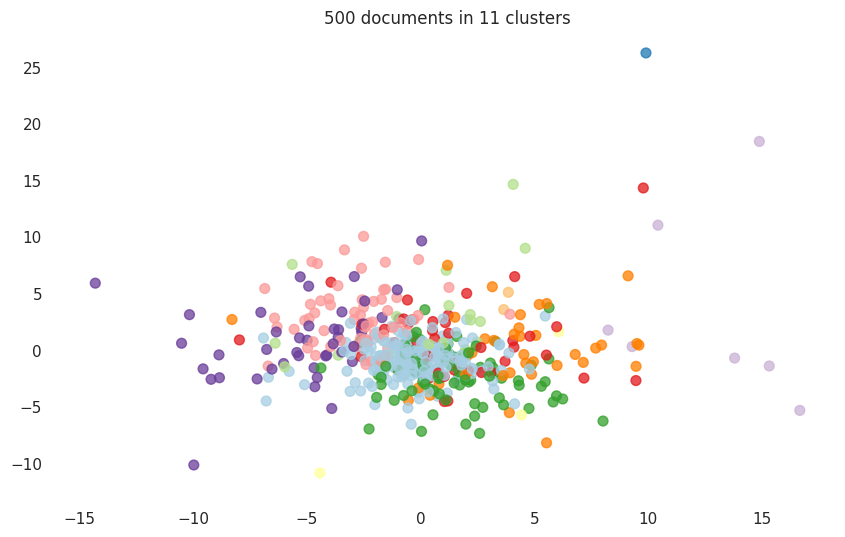

In [58]:
sns.set(rc={'figure.figsize':(10, 6), 'figure.facecolor':'white', 'axes.facecolor':'white'})

color_palette = sns.color_palette('Paired')
# Each cluster gets its own color from the palette
cluster_colors = [color_palette[x] if x >= 0 else (0.5, 0.5, 0.5) for x in clusterer.labels_]
plt.scatter(result[:,0], result[:,1], s=50, c=cluster_colors, alpha=0.75)

plt.title(f'{N_DOCUMENTS} documents in {clusterer.n_clusters} clusters')
plt.show()

We'll add each article's cluster as new column to our combined dataset

In [59]:
metadata_with_clusters = metadata_with_embeddings
metadata_with_clusters['cluster'] = clusters
metadata_with_clusters

,sha,source_x,title,doi,pmcid,pubmed_id,license,abstract,publish_time,authors,...,119,120,121,122,123,124,125,126,127,cluster
cord_uid,,,,,,,,,,,,,,,,,,,,,
ug7v899j,d1aafb70c066a2068b02786f8929fd9c900897fb,PMC,Clinical features of culture-proven Mycoplasma...,10.1186/1471-2334-1-6,PMC35282,11472636,no-cc,OBJECTIVE: This retrospective chart review des...,2001-07-04,"Madani, Tariq A; Al-Ghamdi, Aisha A",...,0.145263,0.296889,0.077305,0.575603,1.250086,-0.314545,-0.319977,-0.089638,0.132216,0
02tnwd4m,6b0567729c2143a66d737eb0a2f63f2dce2e5a7d,PMC,Nitric oxide: a pro-inflammatory mediator in l...,10.1186/rr14,PMC59543,11667967,no-cc,Inflammatory diseases of the respiratory tract...,2000-08-15,"Vliet, Albert van der; Eiserich, Jason P; Cros...",...,0.487589,-0.071829,0.116509,0.911905,0.618028,0.994307,-0.550212,1.302168,0.992603,0
ejv2xln0,06ced00a5fc04215949aa72528f2eeaae1d58927,PMC,Surfactant protein-D and pulmonary host defense,10.1186/rr19,PMC59549,11667972,no-cc,Surfactant protein-D (SP-D) participates in th...,2000-08-25,"Crouch, Erika C",...,-0.510112,0.118183,1.098717,0.885468,2.134356,0.617166,-1.220858,0.322200,2.527758,3
2b73a28n,348055649b6b8cf2b9a376498df9bf41f7123605,PMC,Role of endothelin-1 in lung disease,10.1186/rr44,PMC59574,11686871,no-cc,Endothelin-1 (ET-1) is a 21 amino acid peptide...,2001-02-22,"Fagan, Karen A; McMurtry, Ivan F; Rodman, David M",...,-0.129294,0.778600,1.279774,-0.468407,3.546814,-1.595978,-2.338167,0.574311,2.193070,3
9785vg6d,5f48792a5fa08bed9f56016f4981ae2ca6031b32,PMC,Gene expression in epithelial cells in respons...,10.1186/rr61,PMC59580,11686888,no-cc,Respiratory syncytial virus (RSV) and pneumoni...,2001-05-11,"Domachowske, Joseph B; Bonville, Cynthia A; Ro...",...,0.118098,-0.109738,1.107324,0.188448,1.827301,-1.310135,0.066763,0.332375,0.471162,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
sn1a7ikq,bb3716d66667c66f6f79b37c765388cd334f2cad,PMC,Tylosema esculentum (Marama) Tuber and Bean Ex...,10.1155/2011/284795,PMC3057194,21423688,cc-by,Tylosema esculentum (marama) beans and tubers ...,2011-02-20,"Chingwaru, Walter; Majinda, Runner T.; Yeboah,...",...,-0.282785,2.388615,2.476805,-1.847980,1.875314,-0.309674,-2.363565,-0.676983,-1.168320,9
0gt21051,c44a9d064faca56bd284971828e4db13e656365c; 4040...,PMC,Autonomous Targeting of Infectious Superspread...,10.1371/journal.pcbi.1002015,PMC3060167,21483468,cc-by,"Infectious disease treatments, both pharmaceut...",2011-03-17,"Metzger, Vincent T.; Lloyd-Smith, James O.; We...",...,-2.976055,-0.771656,-0.308590,-0.579366,1.184124,-0.434551,1.663818,-0.973883,2.177636,5
d3a06n3f,6efeb37a50a81c7769a49bcf030e54b148bd1fbd,PMC,Screening of Random Peptide Library of Hemaggl...,10.1371/journal.pone.0018016,PMC3060926,21437206,cc-by,The antigenic structure of the membrane protei...,2011-03-18,"Xu, Wanghui; Han, Lu; Lin, Zhanglin",...,0.666660,-1.394477,-1.269233,-1.244131,0.852521,-1.130056,-1.672238,1.824665,1.386341,0


We can now split our data into two datasets - a **training** one that will be used to train a Machine Learning model, able to determine the cluster that should be assigned to an article, and a **test** one that we'll use to test this classifier.

We will allocate 80% of the articles to training the Machine Learning model, and the remaining 20% to testing it.

In [60]:
train, test = train_test_split(metadata_with_clusters, train_size=0.8)
train

,sha,source_x,title,doi,pmcid,pubmed_id,license,abstract,publish_time,authors,...,119,120,121,122,123,124,125,126,127,cluster
cord_uid,,,,,,,,,,,,,,,,,,,,,
c8yzoen7,02f267368636c422f19d77d3be96de3c0dcbceef,PMC,Hybridization properties of long nucleic acid ...,10.1093/nar/gkq777,PMC2995084,20864443,cc-by-nc,One of the main problems in nucleic acid-based...,2010-09-22,"Öhrmalm, Christina; Jobs, Magnus; Eriksson, Ro...",...,0.864409,-3.519111,-1.746571,-3.618940,2.781140,1.344209,0.439976,-0.642935,2.067099,3
q26f8pv4,62f47ced8c3249f702f0058dc3b6cdb93ca083eb,PMC,DotKnot: pseudoknot prediction using the proba...,10.1093/nar/gkq021,PMC2853144,20123730,cc-by-nc,RNA pseudoknots are functional structure eleme...,2010-01-31,"Sperschneider, Jana; Datta, Amitava",...,0.178397,0.306964,1.270788,-0.265147,-2.186165,-0.068425,-0.058666,2.462060,-3.732440,9
cc5thj1g,315ec823ef271418d0855dc665c0d44341dfcc95,PMC,No Longer an Innocent Bystander: Epithelial To...,10.2119/2008-00035.gribar,PMC2435494,18584047,no-cc,Diseases of mucosal inflammation represent imp...,2008-06-17,"Gribar, Steven C; Richardson, Ward M; Sodhi, C...",...,-1.454083,-1.803592,0.936478,-0.687980,5.798069,0.000513,0.830620,0.212374,3.070191,3
p34ezktf,d77233dd9085c9c76787c84ee9a1e249424b283a,PMC,Australian public health policy in 2003 – 2004,10.1186/1743-8462-2-7,PMC1087471,15811192,cc-by,"In Australia, compared with other developed co...",2005-04-06,"Lin, Vivian; Robinson, Priscilla",...,0.020995,-1.171135,0.872354,0.470898,-0.419167,-0.099814,-0.655957,-0.243394,-0.535846,4
ussnj6ux,7b9e45133c8a6f6c48ec8c5f1f0c01ad0cd1d3ae,PMC,Avipoxviruses: infection biology and their use...,10.1186/1743-422x-8-49,PMC3042955,21291547,cc-by,Avipoxviruses (APVs) belong to the Chordopoxvi...,2011-02-03,"Weli, Simon C; Tryland, Morten",...,4.093131,-0.311020,3.085641,2.940469,-0.115467,-0.233253,-0.144082,-0.489111,-1.609235,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
hxjxczyr,a0b638d10b9ba319ea87b794a6968ca64836a6cb,PMC,Clinical review: Primary influenza viral pneum...,10.1186/cc8183,PMC2811908,20085663,no-cc,Primary influenza pneumonia has a high mortali...,2009-12-21,"Rello, Jordi; Pop-Vicas, Aurora",...,0.217994,-0.132451,0.480841,0.154727,1.704786,0.014593,-0.898992,0.216067,0.449216,3
tex6bgab,404bf0836c388f561f796369c26d0bbf6f37b407,PMC,Small Interfering RNA Targeting M2 Gene Induce...,10.1371/journal.pone.0005671,PMC2682565,19479060,cc-by,RNA interference (RNAi) provides a powerful ne...,2009-05-22,"Sui, Hong-Yan; Zhao, Guang-Yu; Huang, Jian-Don...",...,-0.124007,-0.824316,1.019086,0.209229,0.249752,-1.093161,-0.573710,-0.100929,1.036240,0
7s6283y5,fd5e3020671499cde830bd25de618009ece0af13,PMC,Antiviral and Neuroprotective Role of Octaguan...,10.1371/journal.pntd.0000892,PMC2990691,21124882,cc-by,"BACKGROUND: Japanese encephalitis (JE), caused...",2010-11-23,"Nazmi, Arshed; Dutta, Kallol; Basu, Anirban",...,1.395237,-0.765156,2.551428,-0.482643,0.495961,-0.284661,0.526091,0.660767,-0.059240,2


To speed up training, we'll ignore all columns except the word vectors calculated using Doc2Vec. For this reason, we will create a separate dataset just with the vectors.

In [61]:
columns_to_ignore = ['sha', 'source_x', 'title', 'doi', 'pmcid', 'pubmed_id', 'license', 'abstract', 'publish_time', 'authors', 'journal', 'mag_id',
                     'who_covidence_id', 'arxiv_id', 'pdf_json_files', 'pmc_json_files', 'url', 's2_id' ]
train_data_vectors = train.drop(columns_to_ignore, axis=1)
test_data_vectors = test.drop(columns_to_ignore, axis=1)

## Register the training and testing datasets for AutoML availability

We're registering the training and testing datasets with the Azure Machine Learning datastore to make them available inside Azure Machine Learning Studio and Automated ML.

In [62]:
# Retrieve your ML workspace
ws = Workspace.from_config()
# Retrieve the workspace's default datastore
datastore = ws.get_default_datastore()


Dataset.Tabular.register_pandas_dataframe(train_data_vectors, datastore, 'COVID19Articles_Train_Vectors')
Dataset.Tabular.register_pandas_dataframe(test_data_vectors, datastore, 'COVID19Articles_Test_Vectors')

Validating arguments.
Arguments validated.
Successfully obtained datastore reference and path.
Uploading file to managed-dataset/e6373e14-4b72-4791-8441-b566b74d6fec/
Successfully uploaded file to datastore.
Creating and registering a new dataset.
Successfully created and registered a new dataset.
Validating arguments.
Arguments validated.
Successfully obtained datastore reference and path.
Uploading file to managed-dataset/8b272a0b-416b-42a7-9aae-71f5f6f086d7/
Successfully uploaded file to datastore.
Creating and registering a new dataset.
Successfully created and registered a new dataset.


{
  "source": [
    "('workspaceblobstore', 'managed-dataset/8b272a0b-416b-42a7-9aae-71f5f6f086d7/')"
  ],
  "definition": [
    "GetDatastoreFiles",
    "ReadParquetFile",
    "DropColumns"
  ],
  "registration": {
    "id": "83d0896a-42c6-4b3b-9262-1c9423835814",
    "name": "COVID19Articles_Test_Vectors",
    "version": 2,
    "workspace": "Workspace.create(name='mlw-gai1-f4xzq', subscription_id='23529470-ba17-4d8a-9f0c-064e63a49c33', resource_group='rg-gai1-f4xzq')"
  }
}

## Open Azure Machine Learning Studio

Return to the GitHub repo and follow the instructions from there. You will use Automated ML in Azure Machine Learning Studio to train a classification model that predicts the document cluster for new research articles.